In [ ]:
import networkx as nx
import numpy as np
from scipy.stats import truncnorm
import random
import matplotlib.pyplot as plt
import copy
random.seed(1)

In [ ]:
def create_graph(num_nodes=1000):
    G= nx.Graph()
    for node in range(num_nodes):
        G.add_node(node)
    return G

def visualise_graph(G):
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=False, node_size=2, font_size=8, width =0.1)
    plt.show()

def truncated_gaussian(mean, std_dev, lower_bound, upper_bound, num_samples=1):  # it generates random numbers from a truncated gaussian dist.
    random.seed(1)
    a = (lower_bound - mean) / std_dev
    b = (upper_bound - mean) / std_dev
    truncated_dist = truncnorm(a, b, loc=mean, scale=std_dev)
    #print(truncated_dist.rvs(size=num_samples))
    return truncated_dist.rvs(size=num_samples)

# Creating random number of connections for node using truncated gaussian distribution
def create_num_connections(mean, SD, lower_bound, upper_bound, num_samples):
    return truncated_gaussian(mean, SD, lower_bound, upper_bound, num_samples)

def create_graph_and_connections(num_nodes, mean, SD, lb, ub):
    random.seed(1)
    num_connections = create_num_connections(mean, SD, lb, ub, num_nodes)  # list 0f |num_nodes| numbers showing number of connections/ connections value here
    # Creating edges with random number of edges between lower_bound and upper_bound
    G=create_graph(num_nodes)
    for node in G.nodes:
        num_edges = int(num_connections[node])
        possible_targets = list(G.nodes - {node})  # Avoid self-loops
        targets = random.sample(possible_targets, num_edges)
        for target in targets:
            G.add_edge(node, target)
    adjacency_list = {}
    for node in G.nodes:
        neighbors = list(G.neighbors(node))
        adjacency_list[node] = neighbors
    # Printing adjacency list
    # for node, neighbors in adjacency_list.items():
    #     print(f"{node}: {neighbors}")

    graph=adjacency_list
    return G,graph

In [ ]:
# creating the initial parameters of Activity, Receptiveness, ideology, P, C for each node
def initiate_parameters(num_nodes, mean_ideo, SD_ideo):
    random.seed(1)
    node_values = {}
    mean = 1
    std_dev = 0.1
    lower_bound = 0.9
    upper_bound = 1.1
    samples_act = truncated_gaussian(mean, std_dev, lower_bound, upper_bound, num_nodes)
    samples_rec = truncated_gaussian(mean, std_dev, lower_bound, upper_bound, num_nodes)
    samples_ide = truncated_gaussian(mean_ideo, SD_ideo, -0.8, 0.8, num_nodes)
    for node in range(num_nodes):
        activity=samples_act[node]
        receptiveness=samples_rec[node]
        ideology=samples_ide[node]
        P= activity*ideology
        C= activity*(receptiveness**2)*ideology
        node_values[node] = [activity, receptiveness, ideology, P, C]    # Activity, recep., ideology, P, C

    # To print the initial parameters of the nodes

    # for node, value in node_values.items():
    #     print(f"{node}: {value}")

    return node_values

In [ ]:
def simulate(node_values,graph, e, iter):
    node_data=copy.deepcopy(node_values)  # node -> values dict, values list of 5 - Activity, recep., ideology, P, C
    for _ in range(iter):
        temp_idata = copy.deepcopy(node_data)
        for t in temp_idata:
            temp_idata[t][2]=[]
        #print(temp_idata)
        for p, c in graph.items():
            #print(c)
            a1 = node_data[p][3]
            #print("a1 = ",a1)
            for i in c:
                a2 = temp_idata[i][4]
                #print("a2 = ",a2)
                if (a1>0 and a2>0):
                  temp_idata[i][2].append(node_data[i][2] +((e**(a1)-1)/(e-1))*(e**(-a2)))
                if (a1>0 and a2<0):
                  temp_idata[i][2].append(node_data[i][2] +((e**(a1)-1)/(e-1))*(e**(a2/10)))
                if (a1<0 and a2<0):
                  temp_idata[i][2].append((node_data[i][2] -((e**(-a1)-1)/(e-1))*(e**(a2))))
                #print("New = ", (node_data[i][2] -((e**(-a1)-1)/(e-1))*(e**(a2))))
                if (a1<0 and a2>0):
                  temp_idata[i][2].append((node_data[i][2] -((e**(-a1)-1)/(e-1))*(e**(-a2/10))))

                #print(a2)
                #print(temp_idata[i])
                #print(node_data[i])
        for f in temp_idata:
            tm = node_data[i][2]
            mn = min(temp_idata[f][2])
            mx = max(temp_idata[f][2])
            if mn>tm:
              temp_idata[f][2] =mx
            elif mx<tm:
              temp_idata[f][2] = mn
            else:
             temp_idata[f][2] = sum(temp_idata[f][2])/len(temp_idata[f][2])
            #temp_idata[f][2]=min(temp_idata[f][2])

        for f in temp_idata:
            temp_idata[f][3]= temp_idata[f][0]*temp_idata[f][2]
            if temp_idata[f][3]>1:
              temp_idata[f][3]=1
            temp_idata[f][4]= temp_idata[f][0]*(temp_idata[f][1]**2)*temp_idata[f][2]
        node_data.update(temp_idata)

    ideologies1 = [node_data[j][2] for j in range(len(graph))]
    ideologies2 = [node_values[j][2] for j in range(len(graph))]

    def map_color(ideology):
        if abs(ideology) <= 0.6:
            r = int((255 * (0.6 - abs(ideology)) + 0) / 0.6)
            g = int((255 * (0.6 - abs(ideology)) + 0) / 0.6)
            b = 255
            return '#{:02X}{:02X}{:02X}'.format(r, g, b)
        elif ideology>0.6:
            return '#FF0000'
        else:
            return '#008000'

    node_colors1 = [map_color(y) for y in ideologies1]
    node_colors2 = [map_color(y) for y in ideologies2]

    fig = plt.figure(facecolor='black', figsize=(10, 5))

    ax1 = plt.subplot(1, 2, 1)
    ax1.set_facecolor('black')
    ax1.grid(color='gray', linestyle='--', linewidth=0.5)
    ax1.scatter(range(len(graph)), ideologies1, color=node_colors1, s=10, alpha=0.7)
    ax1.set_xlabel('Number of Nodes', color='white')
    ax1.set_ylabel('Ideologies', color='white')
    ax1.set_title('Ideologies vs Number of Nodes (Final)', color='white')
    ax1.tick_params(axis='x', colors='white')
    ax1.tick_params(axis='y', colors='white')

    ax2 = plt.subplot(1, 2, 2)
    ax2.set_facecolor('black')
    ax2.grid(color='gray', linestyle='--', linewidth=0.5)
    ax2.scatter(range(len(graph)), ideologies2, color=node_colors2, s=10, alpha=0.7)
    ax2.set_xlabel('Number of Nodes', color='white')
    ax2.set_ylabel('Ideologies', color='white')
    ax2.set_title('Ideologies vs Number of Nodes (Initial)', color='white')
    ax2.tick_params(axis='x', colors='white')
    ax2.tick_params(axis='y', colors='white')
    ax1.set_ylim(-1, 1)
    ax2.set_ylim(-1, 1)
    plt.tight_layout()
    plt.show()

    return node_data

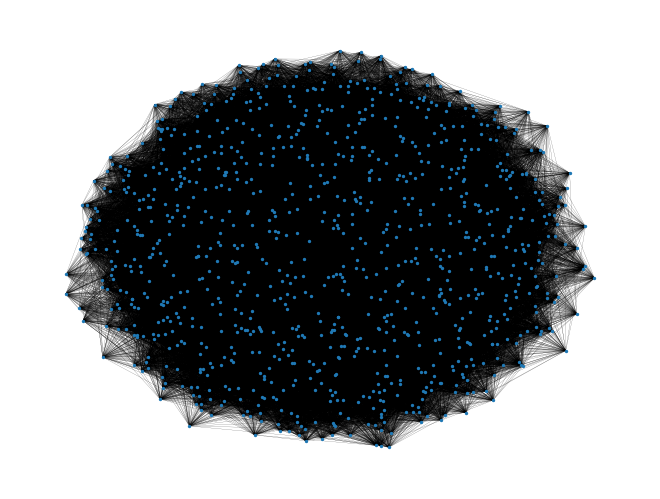

In [ ]:
# Visualizing the graph
G, graph = create_graph_and_connections(1000,50,1,49,51)
visualise_graph(G)

7.7
8.3


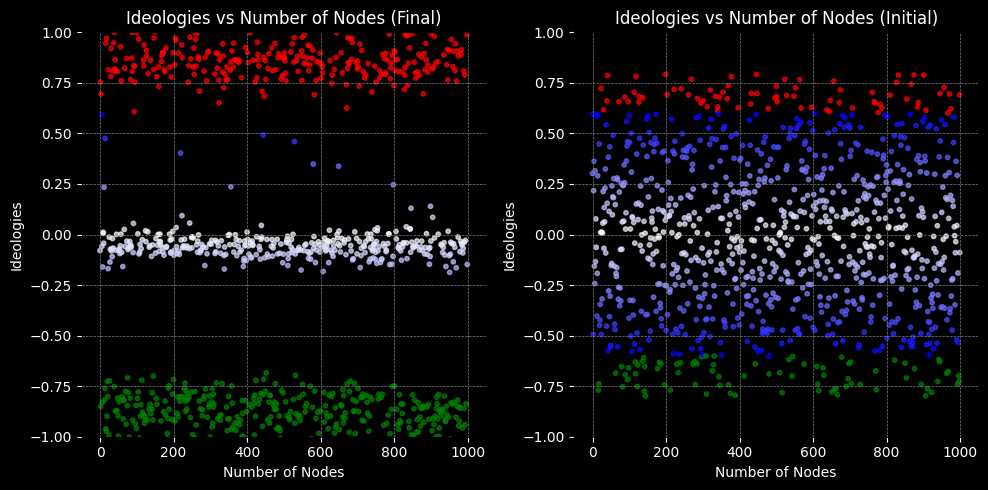

28.4
35.699999999999996


In [ ]:
def calc_perc_red(input_dict, threshold=0.6):
    total_keys = len(input_dict)
    keys_above_threshold = sum(1 for value in input_dict.values() if value[2] > threshold)
    percentage_above_threshold = (keys_above_threshold / total_keys) * 100
    return percentage_above_threshold
def calc_perc_green(input_dict, threshold=-0.6):
    total_keys = len(input_dict)
    keys_above_threshold = sum(1 for value in input_dict.values() if value[2] < threshold)
    percentage_above_threshold = (keys_above_threshold / total_keys) * 100
    return percentage_above_threshold

node_values = initiate_parameters(1000,0,0.6)
print(calc_perc_red(node_values))
print(calc_perc_green(node_values))

a=simulate(node_values,graph,1000,100)

print(calc_perc_red(a))
print(calc_perc_green(a))